# Detection of TOXicity in comments in Spanish (DETOXIS 2021)

## SESIÓN 2.3: Clasificador basado en BERT y evaluación

### Realizado por Álvaro Mazcuñán y Miquel Marín

#### Librerías

In [18]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import re
from statistics import mean
import mxnet as mx
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Leer datos necesarios

In [2]:
df = pd.read_csv("gdrive/MyDrive/DATASET_DETOXIS.csv")
sample_data = df[["comment", "toxicity","toxicity_level"]]
sample_data.head()

,comment,toxicity,toxicity_level
0,Pensó: Zumo para restar.,1,1
1,Como les gusta el afeitado en seco a esta gente.,1,1
2,"asi me gusta, que se maten entre ellos y en al...",1,2
3,"Loss mas valientes, los que mejor cortan nuest...",1,1
4,Costumbres...,1,1


Descarga de la librería `bert_sklearn`

In [12]:
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .
import os
os.chdir("bert-sklearn")
print(os.listdir())

Cloning into 'bert-sklearn'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 516.15 KiB | 19.85 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Processing /content/bert-sklearn
     |████████████████████████████████| 133kB 19.6MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 7.5MB 26.7MB/s 
  Created wheel for bert-sklearn: filename=bert_sklearn-0.3.1-cp37-none-any.whl size=54235 sha256=0e1f20d94caf8076129d967e9932cb576ed359c21e0599555be506f435256ae6
  Stored in directory: /root/.cache/pip/wheels/61/95/c6/5790aae8fb377f5ff356dbe58205aab28858595d6bff8197d0
Successfully built bert-sklearn
ERROR: botocore 1.20.62 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
['setup.py', 'README.md', 'demo_tuning_hyperparams.ipynb', 'bert_sklearn', '.git', 'demo.ipynb', 'tests', 'LICENSE', 'Options.md', 'other_e

In [3]:
from bert_sklearn import BertClassifier
from bert_embedding import BertEmbedding
from sentence_transformers import SentenceTransformer
from bert_sklearn import load_model

Dividir los datos en un conjunto de entrenamiento y de test

In [4]:
random.seed(11)
train_X, test_X, train_Y, test_Y = train_test_split(sample_data['comment'], sample_data['toxicity'], test_size=0.3)

### BERT Classifier

Por defecto utiliza el modelo `bert-base-uncased` de Hugging Face

In [15]:
model = BertClassifier()
model.fit(train_X, train_Y)
y_pred = model.predict(test_X)
model.score(test_X, test_Y) # loss, accuracy
score = f1_score(test_Y, y_pred, average='macro')

100%|██████████| 231508/231508 [00:00<00:00, 21810757.65B/s]

Building sklearn text classifier...
Loading bert-base-uncased model...



100%|██████████| 433/433 [00:00<00:00, 342666.72B/s]


Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 2182, validation data size: 242



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/content/bert-sklearn/bert_sklearn/model/pytorch_pretrained/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)




Epoch 1, Train loss: 0.6356, Val loss: 0.6301, Val accy: 67.77%





Epoch 2, Train loss: 0.6125, Val loss: 0.5731, Val accy: 72.31%





Epoch 3, Train loss: 0.5447, Val loss: 0.5525, Val accy: 71.49%





Loss: 0.6207, Accuracy: 69.10%


In [16]:
score

0.5919642955453848

Tal y como se puede observar, después de entrenar el modelo de Bert durante 3 epochs, se ha obtenido un F1-Score de aproximadamente 0.60, lo cual nos parece un poco bajo, comparado con los modelos que hemos ido obteniendo a lo largo de las entregas que se han ido realizando.

In [13]:
def embeddToBERT(text):
    sentences = re.split('!|\?|\.',text)
    sentences = list(filter(None, sentences)) 

    if bert_version == 'WORD':
        result = bert(sentences, 'avg')
    
        bert_vocabs_of_sentence = []
        for sentence in range(len(result)):
            for word in range(len(result[sentence][1])):
                bert_vocabs_of_sentence.append(result[sentence][1][word])
        feature = [mean(x) for x in zip(*bert_vocabs_of_sentence)]

    elif bert_version == 'SENTENCE':
        result = bert_transformers.encode(sentences)
        feature = [mean(x) for x in zip(*result)]
  
    return feature

In [16]:
bert = BertEmbedding()
bert_version = 'WORD'
bert_word_training_features = train_X.apply(embeddToBERT)
bert_word_test_features = test_X.apply(embeddToBERT)

In [19]:
feature = [x for x in bert_word_training_features.transpose()]
bert_word_training_features = np.asarray(feature)

feature = [x for x in bert_word_test_features.transpose()]
bert_word_test_features = np.asarray(feature)

print(bert_word_training_features.shape)

(2424, 768)


Función para obtener una curva ROC y algunos estadísticos a la hora de interpretar los resultados que se hayan obtenido con distintos modelos junto con BERT

In [20]:
def printResult(y_pred, y_prob):
    acc = accuracy_score(test_Y, y_pred)
    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    cm = confusion_matrix(test_Y,y_pred)
    print('Confusion Matrix:\n', cm)
    print(classification_report(test_Y,y_pred))

    # Plot
    fpr, tpr, thresholds = roc_curve(test_Y, y_prob)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc='lower right')

### Support Vector Machines (SVM)
<p> Word Tokenization Version

In [21]:
model = SVC(kernel ='linear', C = 1)

In [22]:
# Training 
model.fit(bert_word_training_features, train_Y)

# Evaluation
y_pred_bert_words_svm = model.predict(bert_word_test_features)
y_prob_bert_words_svm = model.decision_function(bert_word_test_features)

Accuracy: 64.39

Confusion Matrix:
 [[565 123]
 [247 104]]
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       688
           1       0.46      0.30      0.36       351

    accuracy                           0.64      1039
   macro avg       0.58      0.56      0.56      1039
weighted avg       0.62      0.64      0.62      1039

Area under the ROC curve : 0.631857


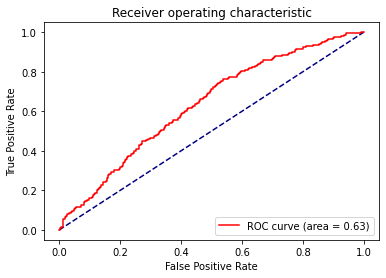

In [23]:
printResult(y_pred_bert_words_svm, y_prob_bert_words_svm) 

<p> Sentence Tokenization Version